# ANN for Image classification

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay




## Load the CIFAR-10 dataset

In [ ]:
epochs = 10
batch_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform= tensor_transform)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform= tensor_transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


### Init the model inputs, output and layer sizes

In [ ]:
inputSize = 32 * 32 * 3 # Every image is 32*32 pixels with 3 RGB channels
# sizes for each hidden layer of the neural netowrk
hiddenSize1 = 4096
hiddenSize2 = 2048
hiddenSize3 = 512
outputSize = 10 # cifar-10 has 10 classes


### Defining the class to develop the neural network

In [ ]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(ANN, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        # Apply the layers sequentially
        x = x.view(-1, 32 * 32 * 3)  # Flatten the input images
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Calling the model with our correct data sizes

In [ ]:
model = ANN(inputSize,hiddenSize1,hiddenSize2,hiddenSize3,outputSize).to(device)


### Loss function and optimizer

In [ ]:
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Training and evaluation functions

In [ ]:
def training(model, lossFunction, optimizer):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_dl, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = lossFunction(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            if i % 200 == 199:  # Print every 200 batches
                avg_loss = running_loss / 200
                accuracy = correct / total
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(train_dl)}], '
                      f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2%}')
                running_loss = 0.0
                correct = 0
                total = 0


def eval(model, dl):
    model.eval()
    with torch.no_grad():
        all_labels = []
        all_predictions = []
        for images, labels in dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    if(dl == test_dl):
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        confusion = confusion_matrix(all_labels, all_predictions)
        print(f"Results for testing: ")
        print(f"Accuracy: {accuracy:.2%}")
        print(f"Precision: {precision:.2%}")
        print(f"Recall: {recall:.2%}")
        confMatrix = ConfusionMatrixDisplay(confusion)
        confMatrix.plot()
    else:
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f'train accuracy : {accuracy:.2%}')


## Training and evaluation

In [ ]:
training(model,lossFunction,optimizer)

Epoch [1/10], Batch [200/500], Loss: 1.9814, Accuracy: 29.80%
Epoch [1/10], Batch [400/500], Loss: 1.6589, Accuracy: 40.99%
Epoch [2/10], Batch [200/500], Loss: 1.4711, Accuracy: 48.09%
Epoch [2/10], Batch [400/500], Loss: 1.4435, Accuracy: 49.21%
Epoch [3/10], Batch [200/500], Loss: 1.3188, Accuracy: 53.24%
Epoch [3/10], Batch [400/500], Loss: 1.3145, Accuracy: 53.68%
Epoch [4/10], Batch [200/500], Loss: 1.1841, Accuracy: 58.18%
Epoch [4/10], Batch [400/500], Loss: 1.2097, Accuracy: 57.07%
Epoch [5/10], Batch [200/500], Loss: 1.0911, Accuracy: 61.72%
Epoch [5/10], Batch [400/500], Loss: 1.1064, Accuracy: 60.83%
Epoch [6/10], Batch [200/500], Loss: 0.9778, Accuracy: 65.66%
Epoch [6/10], Batch [400/500], Loss: 1.0263, Accuracy: 63.20%
Epoch [7/10], Batch [200/500], Loss: 0.8899, Accuracy: 69.02%
Epoch [7/10], Batch [400/500], Loss: 0.9345, Accuracy: 67.07%
Epoch [8/10], Batch [200/500], Loss: 0.8009, Accuracy: 71.76%
Epoch [8/10], Batch [400/500], Loss: 0.8360, Accuracy: 70.38%
Epoch [9

In [ ]:
eval(model,train_dl)

train accuracy : 81.81%


Results for testing: 
Accuracy: 55.40%
Precision: 55.38%
Recall: 55.40%


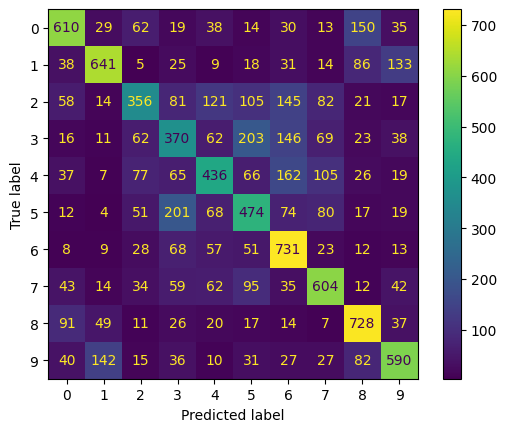

In [ ]:
eval(model,test_dl)

# Using transfer learning with CNNs

## Loading the models

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, outputSize)
vgg16 = vgg16.to(device)
vgg16_optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

googlenet = torchvision.models.googlenet(pretrained=True)
googlenet.fc = nn.Linear(googlenet.fc.in_features, outputSize)
googlenet = googlenet.to(device)
googlenet_optimizer = torch.optim.SGD(googlenet.parameters(), lr=0.01, momentum=0.9)

resnet = torchvision.models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, outputSize)
resnet_model = resnet.to(device)
resnet_model_optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.

## Training and evaluating models

VGG16:
Epoch [1/10], Batch [200/500], Loss: 0.2541, Accuracy: 91.50%
Epoch [1/10], Batch [400/500], Loss: 0.2517, Accuracy: 91.79%
Epoch [2/10], Batch [200/500], Loss: 0.1653, Accuracy: 94.39%
Epoch [2/10], Batch [400/500], Loss: 0.1753, Accuracy: 94.17%
Epoch [3/10], Batch [200/500], Loss: 0.1202, Accuracy: 96.09%
Epoch [3/10], Batch [400/500], Loss: 0.1409, Accuracy: 95.25%
Epoch [4/10], Batch [200/500], Loss: 0.0981, Accuracy: 96.81%
Epoch [4/10], Batch [400/500], Loss: 0.1023, Accuracy: 96.67%
Epoch [5/10], Batch [200/500], Loss: 0.0615, Accuracy: 98.04%
Epoch [5/10], Batch [400/500], Loss: 0.0844, Accuracy: 97.21%
Epoch [6/10], Batch [200/500], Loss: 0.0604, Accuracy: 98.08%
Epoch [6/10], Batch [400/500], Loss: 0.0744, Accuracy: 97.59%
Epoch [7/10], Batch [200/500], Loss: 0.0545, Accuracy: 98.24%
Epoch [7/10], Batch [400/500], Loss: 0.0544, Accuracy: 98.25%
Epoch [8/10], Batch [200/500], Loss: 0.0397, Accuracy: 98.64%
Epoch [8/10], Batch [400/500], Loss: 0.0515, Accuracy: 98.26%
E

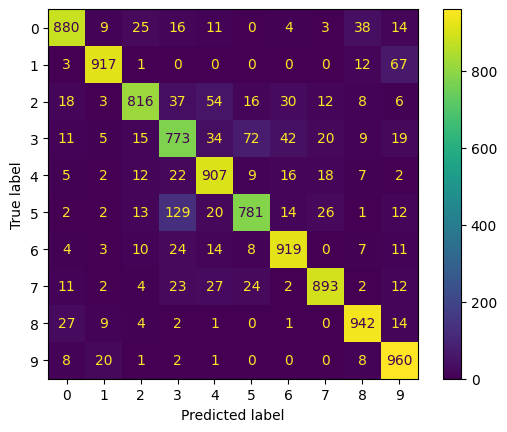

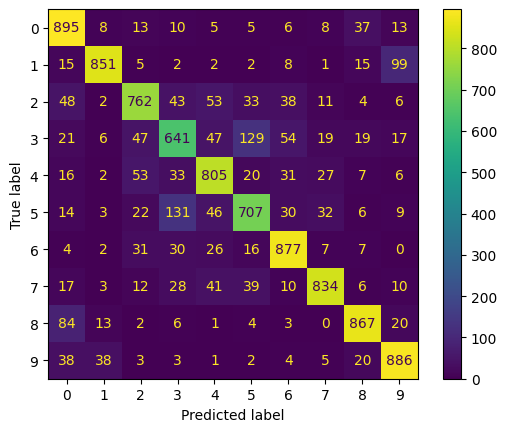

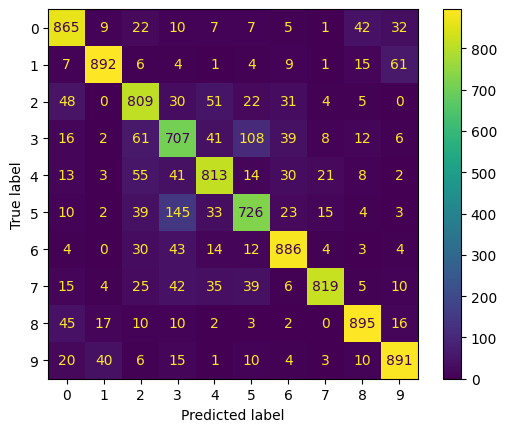

In [ ]:
print("VGG16:")
training(vgg16, lossFunction, vgg16_optimizer)
eval(vgg16, train_dl)
eval(vgg16, test_dl)

print("GoogleNet:")
training(googlenet, lossFunction, googlenet_optimizer)
eval(googlenet, train_dl)
eval(googlenet, test_dl)

print("ResNet:")
training(resnet, lossFunction, resnet_model_optimizer)
eval(resnet, train_dl)
eval(resnet, test_dl)